# **Predicting Wine Quality Through Classification and Regression**
#### DSCI 100 Winter T2 Group 006-042

## Introduction:

Consumer selection of wine has been heavily dependent on quality certifications for purchasing decisions and producers have been doing the same for pricing (Cortez et al., 2009). The certification for wine quality is a tedious process, requiring trained wine assessors to sample the taste and smell of the wine to determine its quality (Cortez et al., 2009). However, there are biases when conducting these sensory taste tests due to the personal preferences of the experts and the complex nature of the human taste bud (Smith and Margolskee, 2001). In a study conducted on 571 wine experts, it was found that there was great variation in the individual's ability to produce repeatable ratings for the same wine (Gawl & Godden, 2008). Therefore, within the wine quality assessment industry, it is common to recruit panels of testers for evaluating and comparing wines for the greatest consistency, which adds to the cost of the assessment.

The lack of consistency and the tedious process of human evaluation suggest that an alternative method for quality evaluation is very desirable. We would like to know whether it is possible to obtain an accurate model to predict wine quality based on its chemical properties, thus, aiding with the quality assessment processes and potentially replacing human sensory evaluators entirely. Furthermore, the analysis raises the question of whether subjective experience or objective measures matter more in making wine quality judgements. For this purpose, we use the K-nearest neighbours (KNN) classification algorithm over the dataset containing the chemical properties and quality scores of 1599 red wine samples.

The data set is collected by Cortez et al. in 2009 and consists of the following variables:

#### Attribute (units):
- Fixed acidity ($g/dm^3$)
- Volatile acidity ($g/dm^3$)
- Citric acid ($g/dm^3$)
- Residual sugar ($g/dm^3$)
- Chlorides ($g/dm^3$)
- Free sulfur dioxide ($mg/dm^3$)
- Total sulfur dioxide ($mg/dm^3$)
- Density ($g/cm^3$)
- pH
- Sulphates ($g/dm^3$)
- Alcohol ($vol.\%$)
- Quality (from 0 to 10)

The quality variable is the average score given by 3 human assessors on a scale of 0-10 (0 being bad and 10 being good). The variables provided have been discussed to have effects on the taste and smell of wine. For example, acidity and alcohol content was found to correspond to the spiciness of the wine (Gutiérrez-Escobar et al., 2021) whereas sulfur dioxide and sulfates (which are primarily used for preservational purposes) impact the aroma and taste of wine (Arapitsas et al., 2018). 

## Methods and Results:

#### Preliminary Exploratory Data Analysis

Firstly, we must load the necessary packages and libraries into R.

In [4]:
# package installations and loading libraries
install.packages("themis")
library(tidyverse)
library(tidymodels)
library(reshape2)
library(gridExtra)
library(recipes) 
library(themis) 

also installing the dependencies ‘fastmatch’, ‘ParamHelpers’, ‘BBmisc’, ‘checkmate’, ‘parallelMap’, ‘XML’, ‘hardhat’, ‘ipred’, ‘mlr’, ‘doParallel’, ‘FNN’, ‘recipes’, ‘generics’, ‘RANN’, ‘ROSE’, ‘unbalanced’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



ERROR: Error: package or namespace load failed for ‘themis’ in loadNamespace(j <- i[[1L]], c(lib.loc, .libPaths()), versionCheck = vI[[j]]):
 namespace ‘generics’ 0.0.2 is already loaded, but >= 0.1.0 is required


Next we downloaded and read the dataset from a public web source.

In [5]:
# downloading and reading the red wine quality dataset into R
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
destination <- "data/red_wine_quality.csv"
download.file(url, destination)

data <- read.csv(destination, head = TRUE, sep = ";")

We replaced the periods separating words with underscores in our variable names to increase legibility and decrease clutter. We chose to exclude zero values so that there would be no interference in our analysis in later processes. The only variable containing zero values was “citric_acid”, which we filtered out accordingly.

In [6]:
# cleaning and wrangling the dataset
colnames(data) <- gsub("\\.", "_", names(data))
colnames(data)[colnames(data) %in% c("free_sulfur_dioxide", "total_sulfur_dioxide")] <- c("free_so2", "total_so2")

clean_data <- data %>%
              mutate(quality = as_factor(quality)) %>%
              filter(citric_acid > 0)

head(clean_data)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_so2,total_so2,density,pH,sulphates,alcohol,quality
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
2,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
3,7.9,0.60,0.06,1.6,0.069,15,59,0.9964,3.30,0.46,9.4,5
4,7.8,0.58,0.02,2.0,0.073,9,18,0.9968,3.36,0.57,9.5,7
5,7.5,0.50,0.36,6.1,0.071,17,102,0.9978,3.35,0.80,10.5,5
6,6.7,0.58,0.08,1.8,0.097,15,65,0.9959,3.28,0.54,9.2,5


*Table 1: Small preview of the clean dataset.*

The dataset was split so that we can create and tune our model from a subset of the original data and test its accuracy on another, enabling us to create our classifier so that it is not influenced by the training procedure. We decided to split the dataset into a 3:2 ratio (i.e. 60% training and 40% testing) as we will be requiring a larger testing set to better evaluate how well our model can be generalized towards other wine classifications. Note that to make our analysis reproducible, we set the same seed throughout the analysis.

In [7]:
# splitting data into a training and testing dataset
set.seed(7)
clean_data_split <- initial_split(clean_data, prop = 0.6, strata = quality)
train_data <- training(clean_data_split)
test_data <- testing(clean_data_split)

Next, we wanted to see how balanced our quality classes are in the training set we created.

In [8]:
# counting the number of observations per our quality classifier
train_data_quality_summary <- train_data %>%
                              group_by(quality) %>%
                              summarize(count = n(),
                                        proportion = n() / nrow(train_data) * 100)
train_data_quality_summary

`summarise()` ungrouping output (override with `.groups` argument)



quality,count,proportion
<fct>,<int>,<dbl>
3,1,0.1135074
4,24,2.7241771
5,378,42.9057889
6,354,40.1816118
7,112,12.7128263
8,12,1.3620885


*Table 2: Count and proportion of quality classes in our training data.*

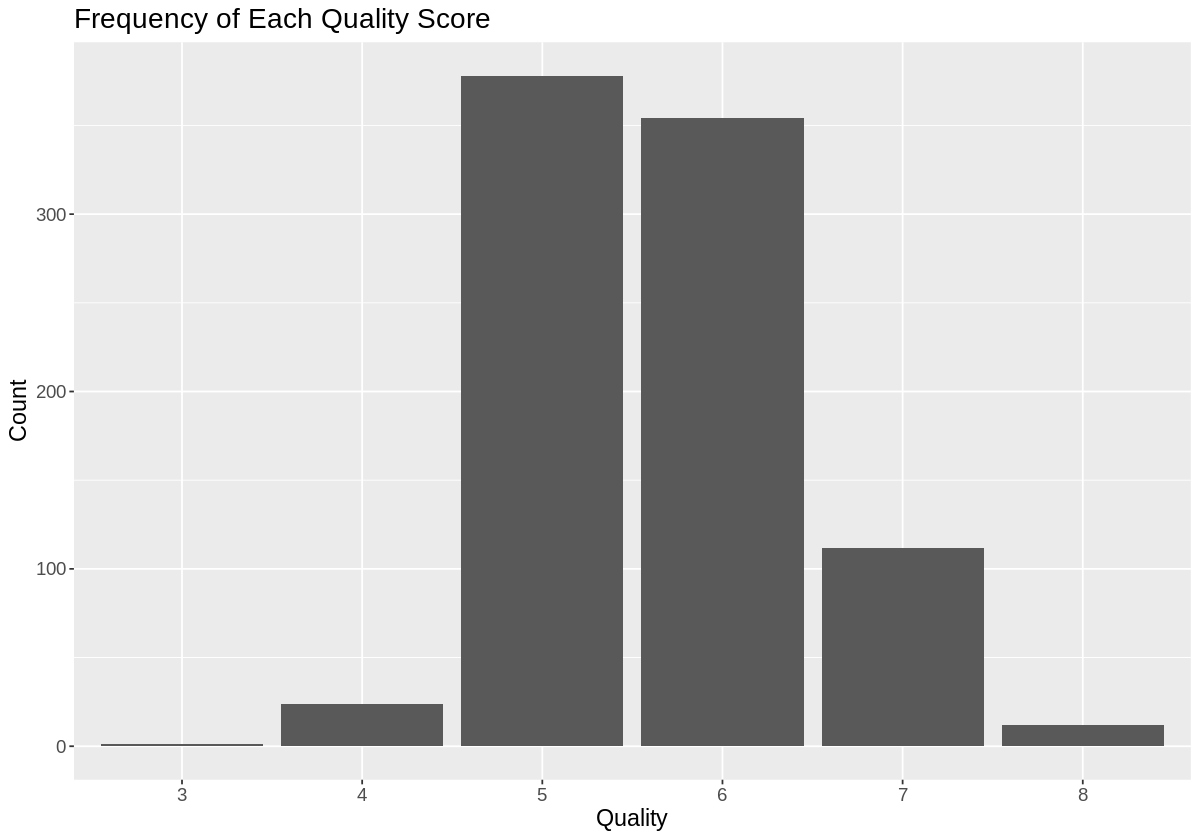

In [9]:
# count of observations per classifier plot
options(repr.plot.width = 10, options.repr.plot.height = 15)

train_data_quality_summary_plot <- train_data_quality_summary %>%
                                   ggplot(aes(x = quality, y = count)) +
                                   geom_bar(stat = "identity") +
                                   labs(x = "Quality", y = "Count", title = "Frequency of Each Quality Score") +
                                   theme(text = element_text(size = 14))
train_data_quality_summary_plot

*Figure 1: Counts for every observable quality class in the training dataset.*

From Table 2 and Figure 1, it is clear that there is a disproportionate number of wine quality classifications in our data set, with more classified in the average quality categories and less in the extreme categories.

#### Data Analysis

Our data analysis will be conducted using a classification model through KNN algorithm. This algorithm finds neighbouring points with the nearest Euclidean distances to the unknown observation and predicts its category by a majority classifier. Meaning that the closest points “vote” on the class of the new observation. Depending on how many 'neighbours' we use, the accuracy may change. We must prevent overfitting the data to the noisy training dataset and underfitting our model, as both reduce overall prediction accuracy. Thus, it is important we pick the appropriate k value in our model to create the best model for predicting subsequent novel observations accurately.

We begin by using predictor variable selection to find the best predictors in our model before tuning the model with different values of k to determine the best number of neighbours for our classifier. After obtaining the best k value, we evaluate the accuracy of our model on a test set.

#### Predictor Selection of Our First Model

Initially starting with eleven possible predictor variables, we have since reduced this to a mere subset to prevent anything irrelevant from negatively affecting our model. Irrelevant predictors may augment the distances between observations, which thus compromise the accuracy of the model. Additionally, using a subset of predictors would reduce computational time complexity.

We obtained the best predictor variables via the forward selection method using R, as the subset selection method would be too computationally expensive and inefficient on large datasets.

We used the code provided in the textbook to undergo our forward selection predictor analysis (Timbers et al., 2022). This code utilizes iterative processes using for-loops, model formulas, and workflows to tune a KNN classifier with cross-validation to obtain the accuracy of each predictor string. The resulting accuracies were put into the empty data frame to compare each model string.

In [7]:
set.seed(7)

# determining predictors
data_subset <- train_data
names <- colnames(data_subset %>% select(-quality))

In [8]:
# empty tibble to store results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# model specification
spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")

# 5-fold cross-validation object
data_vfold <- vfold_cv(data_subset, v = 5, strata = quality)

In [9]:
# storing the total number of predictors
n_total <- length(names)

# storing selected predictors
selected <- c()

In [10]:
set.seed(7)

# the first for loop - for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    
# for every predictor still not added yet
accs <- list()
models <- list()

# for the second for loop - adds best predictor in the next model string
for (j in 1:length(names)) {
        
# model string for the combination of predictors
preds_new <- c(selected, names[[j]])
model_string <- paste("quality", "~", paste(preds_new, collapse="+"))
        
# recipe created from the model string
data_recipe <- recipe(as.formula(model_string), 
                data = data_subset) %>%
                step_scale(all_predictors()) %>%
                step_center(all_predictors())

# tuning the KNN classifier with the recipe and model specification then collecting the accuracy for the best K.
acc <- workflow() %>%
        add_recipe(data_recipe) %>%
        add_model(spec) %>%
        tune_grid(resamples = data_vfold, grid = 10) %>%
        collect_metrics() %>%
        filter(.metric == "accuracy") %>%
        summarize(mx = max(mean))

acc <- acc$mx %>% unlist()
    
# adding best k to the dataframe
accs[[j]] <- acc
models[[j]] <- model_string
}
    
jstar <- which.max(unlist(accs))
    
accuracies <- accuracies %>% 
              add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    
selected <- c(selected, names[[jstar]])
    
names <- names[-jstar]
}

accuracies

! Fold1: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold2: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold4: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold5: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold1: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold2: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold4: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold5: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold1: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold2: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold4: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold5: internal: No observations were detected in `t

size,model_string,accuracy
<int>,<chr>,<dbl>
1,quality ~ alcohol,0.5197869
2,quality ~ alcohol+sulphates,0.5777369
3,quality ~ alcohol+sulphates+total_so2,0.6038676
4,quality ~ alcohol+sulphates+total_so2+residual_sugar,0.6174786
5,quality ~ alcohol+sulphates+total_so2+residual_sugar+chlorides,0.6230250
6,quality ~ alcohol+sulphates+total_so2+residual_sugar+chlorides+volatile_acidity,0.6356094
7,quality ~ alcohol+sulphates+total_so2+residual_sugar+chlorides+volatile_acidity+free_so2,0.6299080
8,quality ~ alcohol+sulphates+total_so2+residual_sugar+chlorides+volatile_acidity+free_so2+citric_acid,0.6220242
9,quality ~ alcohol+sulphates+total_so2+residual_sugar+chlorides+volatile_acidity+free_so2+citric_acid+fixed_acidity,0.6255432


*Table 3: Predictors model and accuracy results obtained from forward selection.*

Table 3 suggests that using six predictor variables (residual_sugar, alcohol, sulphates, total_so2, chlorides, volatile_acidity) would provide the best accuracy (~64%). We used these variables in the remaining analysis accordingly.

#### Finding the Best K value in our classifier

Using our selected predictor variables, we begin tuning the classifier.

Tuning the classifier, we determined the best k using cross-validation. Through a workflow, we tuned the model to values of k ranging from 1-100 by 5. We collected the resulting accuracies of the folds and plotted them over k-neighbours.

! Fold2: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold3: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold4: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold5: internal: No observations were detected in `truth` for level(s): '3'
Com...



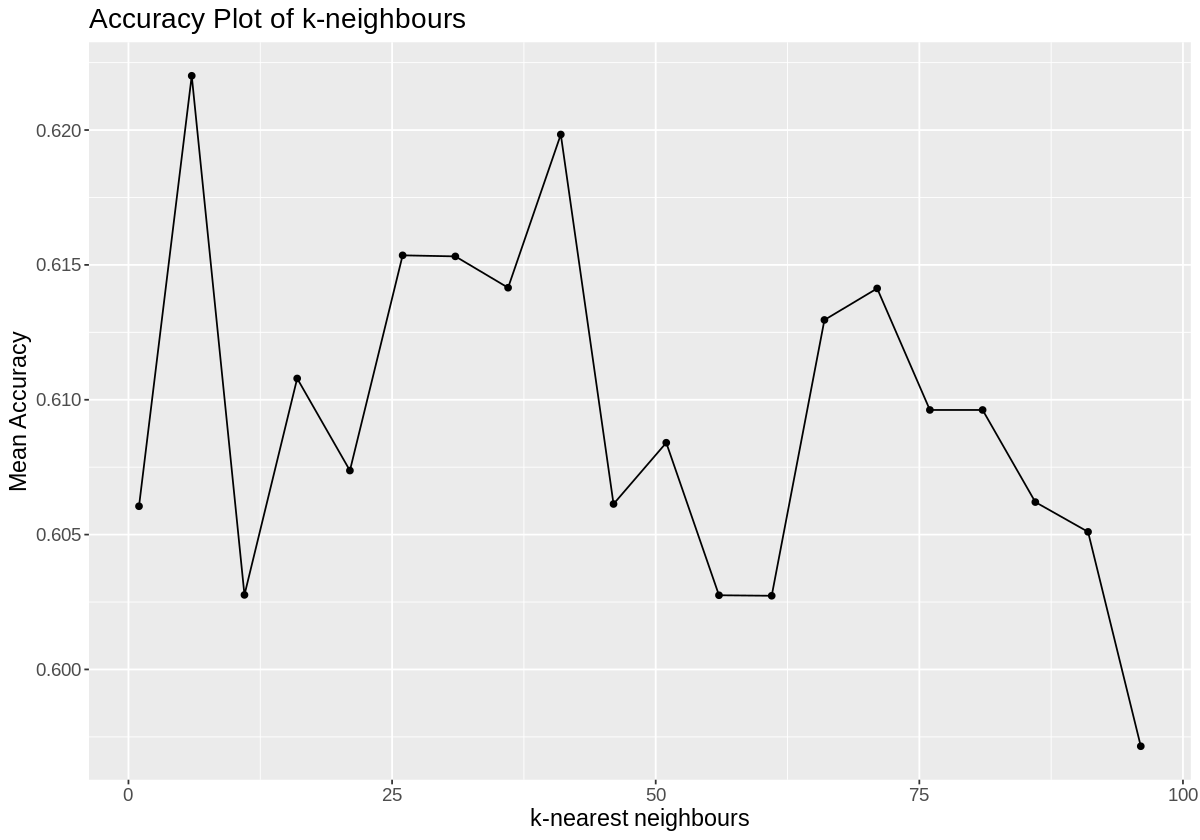

In [11]:
set.seed(7)

# selecting only relevant predictor variables
predictor_train_data <- train_data %>%
                        select(c(quality, alcohol, sulphates, total_so2, residual_sugar, chlorides, volatile_acidity))

# recipe specifying the use of all predictor variables on predicting quality
recipe <- recipe(quality ~., data = predictor_train_data) %>%
            step_scale(all_predictors()) %>%
            step_center(all_predictors())

# tuning the model and specifying k-nn classification 
model <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn") %>%
            set_mode("classification")

# creating the 5-fold cross-validation object
vfold <- vfold_cv(predictor_train_data, v = 5, strata = quality)

# range of k values tested
k_vals <- tibble(neighbors = seq(1,100,5))

# tuning the model in a workflow
train_fit <- workflow() %>%
                add_recipe(recipe) %>%
                add_model(model) %>%
                tune_grid(resamples = vfold, grid = k_vals) %>%
                collect_metrics() %>%
                filter(.metric == "accuracy") %>%
                arrange(mean)

# plotting accuracies by k values
k_plot <- ggplot(train_fit, aes(x=neighbors, y=mean)) + geom_point() + geom_line() +
                                   labs(x = "k-nearest neighbours", y = "Mean Accuracy", title = "Accuracy Plot of k-neighbours") +
                                   theme(text = element_text(size = 14))
k_plot

*Figure 2.1: Plot of k-neighbours (1-100 by 5) against accuracy in cross-validation.*

Observing Figure 2.1, we see a variable plot of accuracy. We attribute this high variability to the inherent properties of raw data. The best range of k values appears to be within 25-60 with accuracies around 0.61. We decided to repeat the model tuning procedure using k values within the specified range above to see if we can obtain a more stable plot to help identify the best k. We tuned and plotted the accuracy of the model once more for values of k ranging from 25-60 by 2.

! Fold2: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold3: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold4: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold5: internal: No observations were detected in `truth` for level(s): '3'
Com...



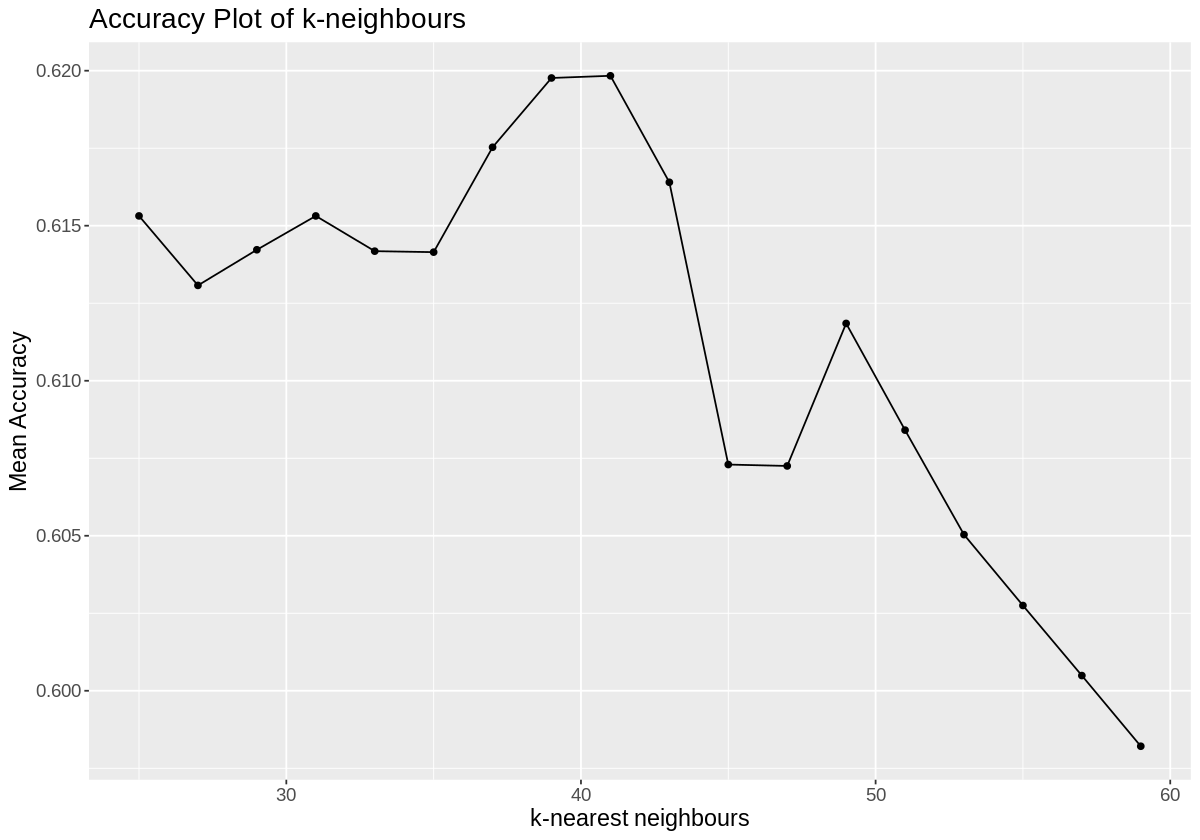

In [11]:
set.seed(7)

# selecting only relevant predictor variables
predictor_train_data <- train_data %>%
                        select(c(quality, alcohol, sulphates, total_so2, residual_sugar, chlorides, volatile_acidity))

# recipe specifying the use of all predictor variables on predicting quality
recipe <- recipe(quality ~., data = predictor_train_data) %>%
            step_scale(all_predictors()) %>%
            step_center(all_predictors())

# tuning the model and specifying k-nn classification 
model <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
            set_engine("kknn") %>%
            set_mode("classification")

# creating the 5-fold cross-validation object
vfold <- vfold_cv(predictor_train_data, v = 5, strata = quality)

# new range of k values being tested
k_vals_2 <- tibble(neighbors = seq(25,60,2))

# tuning the model in a workflow
train_fit_2 <- workflow() %>%
                add_recipe(recipe) %>%
                add_model(model) %>%
                tune_grid(resamples = vfold, grid = k_vals_2) %>%
                collect_metrics() %>%
                filter(.metric == "accuracy") %>%
                arrange(mean)

k_plot_2 <- ggplot(train_fit_2, aes(x=neighbors, y=mean)) + geom_point() + geom_line() +
                                   labs(x = "k-nearest neighbours", y = "Mean Accuracy", title = "Accuracy Plot of k-neighbours") +
                                   theme(text = element_text(size = 14))
k_plot_2

*Figure 2.2: Plot of k values (25-60 by 2) against accuracy in cross-validation.*

In [12]:
# seeing accuracies of our cross-validation 
tail(train_fit_2)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
31,accuracy,multiclass,0.6153158,5,0.01664749,Model04
25,accuracy,multiclass,0.6153163,5,0.01139492,Model01
43,accuracy,multiclass,0.6164010,5,0.01265192,Model10
37,accuracy,multiclass,0.6175309,5,0.01377702,Model07
39,accuracy,multiclass,0.6197653,5,0.01130418,Model08
41,accuracy,multiclass,0.6198360,5,0.01405499,Model09


*Table 4: Estimation accuracies of k-neighbours in cross-validation.*

Remarking on Figure 2.2, we found that k=39 would be our best choice, with an accuracy of ~0.62 (see Table 4). The plot peaks around the late '30s then slowly declines just after 40. This decline at the end suggests underfitting. Therefore, choosing the peak accuracy at k=41 might be too risky. Additionally, the standard error for k=39 is lower than that of 41. Consequently, we picked the second-highest accuracy at k=39, where surrounding values remain relatively stable.

We retrained our model to k=39 and evaluated its accuracy on the test dataset to see how generalizable the results are to future observations.

In [18]:
set.seed(7)

# selecting only relevant predictor variables
predictor_train_data <- train_data %>%
                        select(c(quality, alcohol, sulphates, total_so2, residual_sugar, chlorides, volatile_acidity))

# recipe specifying the use of all predictor variables on predicting quality
recipe <- recipe(quality ~., data = predictor_train_data) %>%
            step_scale(all_predictors()) %>%
            step_center(all_predictors())

# retraining the model with k = 39
best_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 39) %>%
set_engine("kknn") %>%
set_mode("classification")

# fitting the recipe and model specification onto the training data
best_train_fit <- workflow() %>%
                add_recipe(recipe) %>%
                add_model(best_model) %>%
                fit(predictor_train_data)

# creates a prediction on the test data
predicted <- predict(best_train_fit, test_data) %>%
             bind_cols(test_data)

In [19]:
# prediction accuracy of our model on the test data 
predict_accuracy <- predicted %>%
                    metrics(truth = quality, estimate = .pred_class) %>%
                    filter(.metric == "accuracy")
predict_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.556314


*Table 5: Evaluation accuracy of the best model (k = 39) on test data.*

As determined by Table 5, we see that the accuracy of our model is ~0.56. This is slightly lower than our best k model (Table 4) in the tuning procedure. Lower accuracy is expected since the training data used to create the model would have at least some influence on the model's accuracy during cross-validation.

### Considering the Quality Class Imbalance on our Model

In Figure 1, there is a disproportionately low amount of observations that fall under the low/high ends of the quality score range. We consider them to be “rare classes”. As the majority of observations have a score of 5 or 6, the model already has a good chance of predicting right for 5 or 6 each time. To avoid bias from the dataset, we tested our model on only the rare classes which gave insight to how well our model truly performs.

In [20]:
set.seed(7)

test_data_rare <- test_data %>% filter(quality %in% c(3,4,8))

# prediction accuracy of our model on the rare quality observations of the test data 
predict_accuracy_rare <- predict(best_train_fit, test_data_rare) %>%
                            bind_cols(test_data_rare) %>%
                            metrics(truth = quality, estimate = .pred_class) %>%
                            filter(.metric == "accuracy")
predict_accuracy_rare

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0


*Table 6: Accuracy on rare-occurring quality classes (quality = 3, 4, and 8).*

The accuracy obtained in Table 6 reveals that the model performs very poorly on rare classes, suggesting that those rare classes are affecting the model’s accuracy, perhaps to an imbalancing effect.

We wanted to see if the low accuracy in predicting rare classes relates to the quality class imbalance in our analysis or if it relates to how variable and unstable the subjective classification of these extreme classes is.

To test this, we upsampled the lower counts to match those with higher counts in our recipe and proceeded with the analysis as previously done to tune our K-NN model. We want to see if our best model yields a different evaluation accuracy if it includes upsampling.

The same steps were used as done previously to find the best predictor variables, the best k value in cross-validation, and to evaluate the accuracy of our model on the test data.

In [13]:
set.seed(7)

# determining predictors
data_subset <- train_data
names_2 <- colnames(data_subset %>% select(-quality))

# empty tibble to store results
accuracies_2 <- tibble(size = integer(), 
                     model_string_2 = character(), 
                     accuracy = numeric())

# model specification
spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")

# 5-fold cross-validation object
data_vfold <- vfold_cv(data_subset, v = 5, strata = quality)

# storing the total number of predictors
n_total_2 <- length(names_2)

# storing selected predictors
selected_2 <- c()

# the first for loop - for every size from 1 to the total number of predictors
for (i in 1:n_total_2) {
    
# for every predictor still not added yet
accs_2 <- list()
models_2 <- list()

# for the second for loop - adds best predictor in the next model string
for (j in 1:length(names_2)) {
        
# model string for the combination of predictors
preds_new_2 <- c(selected_2, names_2[[j]])
model_string_2 <- paste("quality", "~", paste(preds_new_2, collapse="+"))
        
# recipe created from the model string
data_recipe_2 <- recipe(as.formula(model_string_2), 
                data = data_subset) %>%
                step_scale(all_predictors()) %>%
                step_center(all_predictors()) %>% 
                step_upsample(quality, over_ratio = 1)

# tuning the KNN classifier with the recipe and model specification then collecting the accuracy for the best K.
acc_2 <- workflow() %>%
        add_recipe(data_recipe_2) %>%
        add_model(spec) %>%
        tune_grid(resamples = data_vfold, grid = 10) %>%
        collect_metrics() %>%
        filter(.metric == "accuracy") %>%
        summarize(mx = max(mean))

acc_2 <- acc_2$mx %>% unlist()
    
# adding best k to the dataframe
accs_2[[j]] <- acc_2
models_2[[j]] <- model_string_2
}
    
jstar_2 <- which.max(unlist(accs_2))
    
accuracies_2 <- accuracies_2 %>% 
              add_row(size = i, 
              model_string_2 = models_2[[jstar_2]], 
              accuracy = accs_2[[jstar_2]])
    
selected_2 <- c(selected_2, names_2[[jstar_2]])
    
names_2 <- names_2[-jstar_2]
}

accuracies_2

! Fold1: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold2: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold4: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold5: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold1: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold2: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold4: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold5: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold1: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold2: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold4: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold5: internal: No observations were detected in `t

size,model_string_2,accuracy
<int>,<chr>,<dbl>
1,quality ~ volatile_acidity,0.4108862
2,quality ~ volatile_acidity+density,0.5414108
3,quality ~ volatile_acidity+density+alcohol,0.5618789
4,quality ~ volatile_acidity+density+alcohol+chlorides,0.5732817
5,quality ~ volatile_acidity+density+alcohol+chlorides+total_so2,0.5970492
6,quality ~ volatile_acidity+density+alcohol+chlorides+total_so2+free_so2,0.6028281
7,quality ~ volatile_acidity+density+alcohol+chlorides+total_so2+free_so2+sulphates,0.5903341
8,quality ~ volatile_acidity+density+alcohol+chlorides+total_so2+free_so2+sulphates+residual_sugar,0.5935690
9,quality ~ volatile_acidity+density+alcohol+chlorides+total_so2+free_so2+sulphates+residual_sugar+pH,0.6094270


*Table 7: Forward selection on upsampled data.*

We decided on using the six predictor variables. Although it does not have the highest accuracy, it is more practical than choosing the 10 or 11 variables.

! Fold1: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold2: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold4: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold5: internal: No observations were detected in `truth` for level(s): '3'
Com...



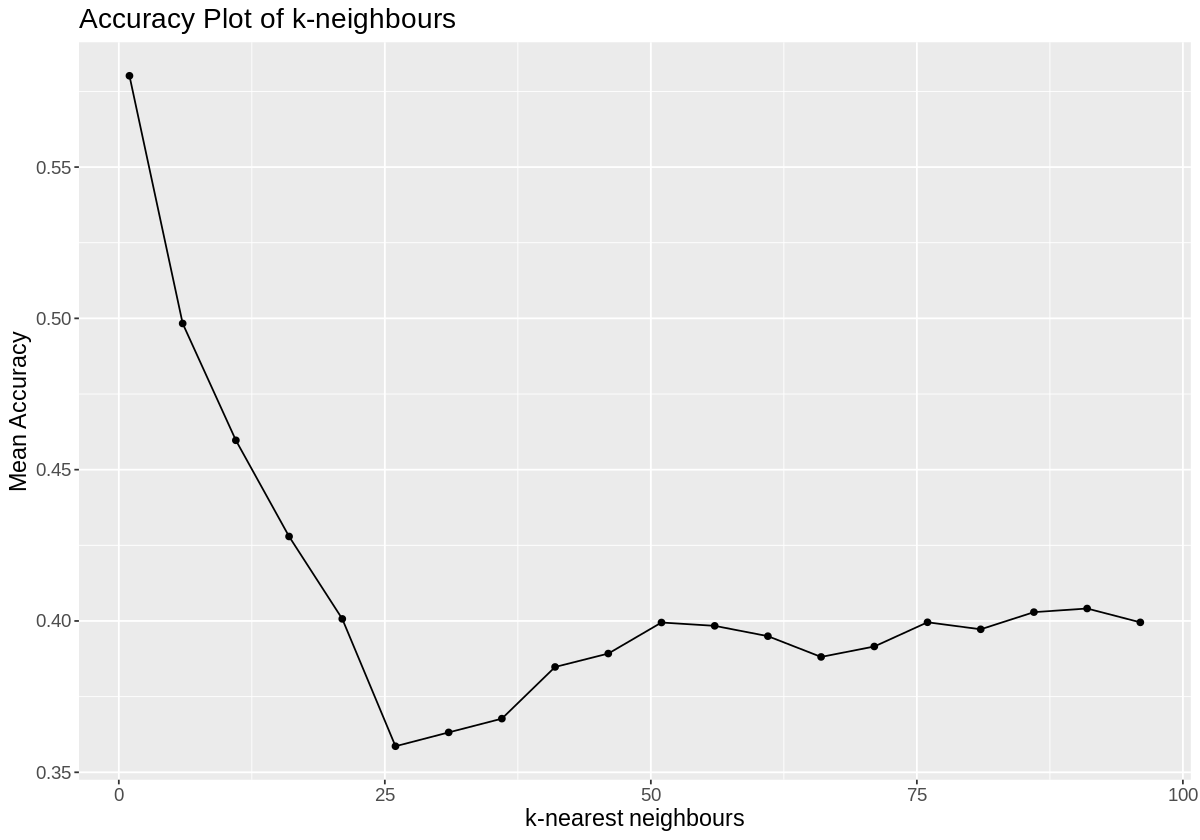

In [14]:
set.seed(7)

# selecting only relevant predictor variables
predictor_train_data <- train_data %>%
                        select(c(quality, volatile_acidity, density, alcohol, chlorides, total_so2, free_so2))

# creating the 5-fold cross-validation object
vfold <- vfold_cv(predictor_train_data, v = 5, strata = quality)

# range of k values tested
k_vals <- tibble(neighbors = seq(1,100,5))

# recipe to balance classes
recipe_balance <- recipe(quality ~., data = predictor_train_data) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) %>% 
    step_upsample(quality, over_ratio = 1)

# model specification
upsample_model <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
set_engine("kknn") %>%
set_mode("classification")

# fitting the recipe and model specification onto the training data
balanced_tune <- workflow() %>%
                add_recipe(recipe_balance) %>%
                add_model(upsample_model) %>%
                tune_grid(resamples = vfold, grid = k_vals) %>%
                collect_metrics() %>%
                filter(.metric == "accuracy") %>%
                arrange(mean)

# plotting accuracies by k values
k_plot_balance <- ggplot(balanced_tune, aes(x=neighbors, y=mean)) + geom_point() + geom_line() +
                                   labs(x = "k-nearest neighbours", y = "Mean Accuracy", title = "Accuracy Plot of k-neighbours") +
                                   theme(text = element_text(size = 14))
k_plot_balance

*Figure 4: Accuracy plot of k-neighbours (1-100) in the upsampled cross-validation.*

This yields a poor plot of accuracy. To see if there is a stable high accuracy value, we limit the range to values 1-15.

Warning message:
“`step_upsample()` is deprecated as of recipes 0.1.13.
Please use `themis::step_upsample()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”
! Fold1: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold2: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold4: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold5: internal: No observations were detected in `truth` for level(s): '3'
Com...



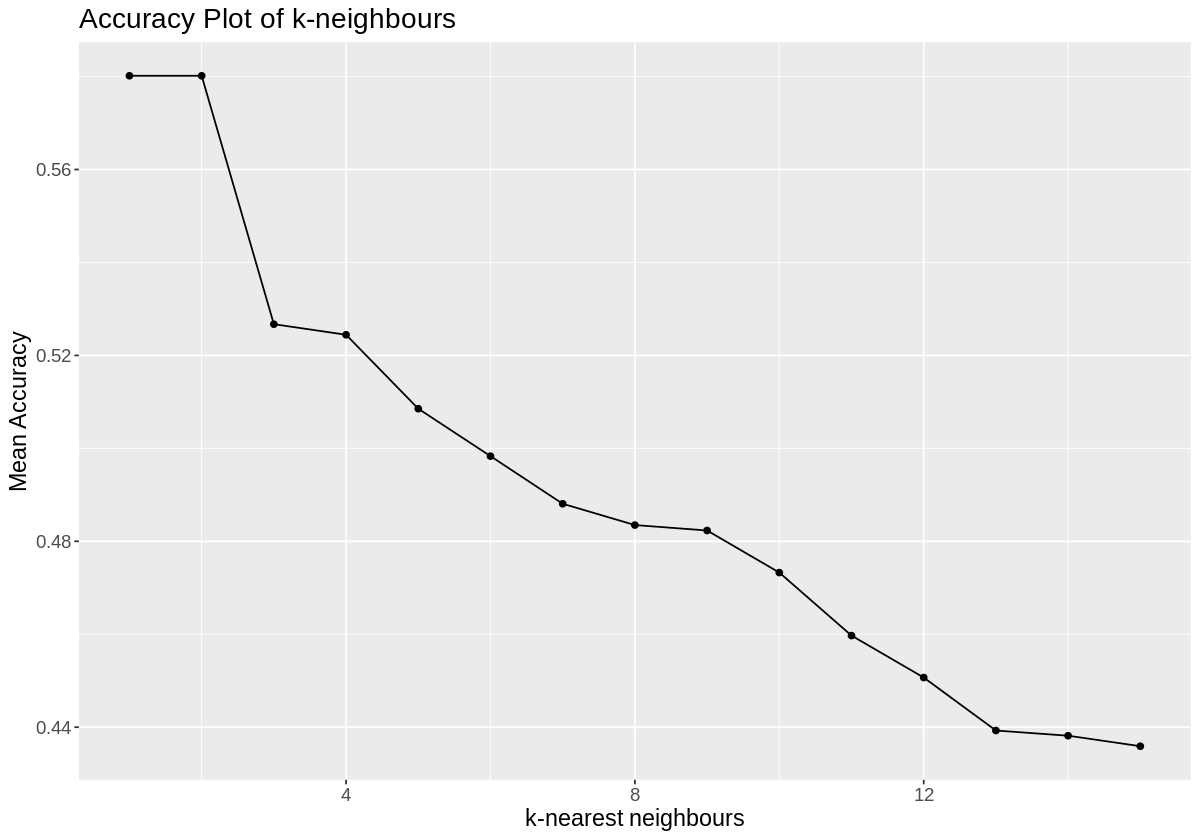

In [13]:
set.seed(7)

# selecting only relevant predictor variables
predictor_train_data <- train_data %>%
                        select(c(quality, volatile_acidity, density, alcohol, chlorides, total_so2, free_so2))

# creating the 5-fold cross-validation object
vfold <- vfold_cv(predictor_train_data, v = 5, strata = quality)

# range of k values tested
k_vals_balance <- tibble(neighbors = seq(1,15,1))

# recipe to balance classes
recipe_balance <- recipe(quality ~., data = predictor_train_data) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) %>% 
    step_upsample(quality, over_ratio = 1)

# model specification
upsample_model <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
set_engine("kknn") %>%
set_mode("classification")

# fitting the recipe and model specification onto the training data
balanced_tune2 <- workflow() %>%
                add_recipe(recipe_balance) %>%
                add_model(upsample_model) %>%
                tune_grid(resamples = vfold, grid = k_vals_balance) %>%
                collect_metrics() %>%
                filter(.metric == "accuracy") %>%
                arrange(mean)

# plotting accuracies by k values
k_plot_balance2 <- ggplot(balanced_tune2, aes(x=neighbors, y=mean)) + geom_point() + geom_line() +
                                   labs(x = "k-nearest neighbours", y = "Mean Accuracy", title = "Accuracy Plot of k-neighbours") +
                                   theme(text = element_text(size = 14))
k_plot_balance2

*Figure 5: Accuracy plot of k-neighbours (1-15) in the upsampled cross-validation.*

In [14]:
tail(balanced_tune2)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
6,accuracy,multiclass,0.4983180,5,0.01295943,Model06
5,accuracy,multiclass,0.5085262,5,0.01780376,Model05
4,accuracy,multiclass,0.5244358,5,0.01755747,Model04
3,accuracy,multiclass,0.5267086,5,0.01681556,Model03
1,accuracy,multiclass,0.5801646,5,0.01779827,Model01
2,accuracy,multiclass,0.5801646,5,0.01779827,Model02


*Table 8: Top accuracies of k-neighbours in upsampled cross-validation*

The highest accuracy (Table 8) k values seem to be at high risk of overfitting the data. Nevertheless, we chose a k value of 3 to test the evaluation accuracy of our test data. This was chosen based on its low standard error and high accuracy.

In [21]:
set.seed(7)

# selecting only relevant predictor variables
predictor_train_data <- train_data %>%
                        select(c(quality, volatile_acidity, density, alcohol, chlorides, total_so2, free_so2))

# recipe to balance classes
recipe_balance <- recipe(quality ~., data = predictor_train_data) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) %>% 
    step_upsample(quality, over_ratio = 1)

# model specification
upsample_best_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) %>%
set_engine("kknn") %>%
set_mode("classification")

# fitting the recipe and model specification onto the training data
balanced_upsample_best <- workflow() %>%
                add_recipe(recipe_balance) %>%
                add_model(upsample_best_model) %>%
                fit(predictor_train_data) 

# creates a prediction on the test data
predicted_upsample <- predict(balanced_upsample_best, test_data) %>%
             bind_cols(test_data)
                           
# prediction accuracy of our model on the test data 
balance_pred_acc <- predicted_upsample %>%
                    metrics(truth = quality, estimate = .pred_class) %>%
                    filter(.metric == "accuracy")
balance_pred_acc

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5136519


*Table 9: Evaluation accuracy of our best upsampled model on the test data.*

In [23]:
set.seed(7)

# test the accuracy of the upsampled model on rare classes
rare_pred_acc <- predict(balanced_upsample_best, test_data_rare) %>%
                            bind_cols(test_data_rare) %>%
                            metrics(truth = quality, estimate = .pred_class) %>%
                            filter(.metric == "accuracy")
rare_pred_acc

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.06451613


*Table 10: Evaluation accuracy of our best upsampled model on the test data using only rare classes.*

The accuracy of our upsampled model on the test data is lower than the model we did before upsampling. 

Upsampling the dataset improved the accuracy of the classifier on rare classes, but only by a miniscule amount. This suggests that the low accuracy of the original model was unlikely due to the class imbalance of the dataset.

### Visualization

Observing the results in detail, we display the predictions made by our model on the test set via a confusion matrix. We chose not to visualize the upsampled model because it was less accurate than our original model. Reading from top-left and then down along the diagonal denotes the count of quality predictions made by our model that match its true classification in the test set. All other positions in the matrix denote incorrect predictions.

In [25]:
# generates a confusion matrix for original model
confusion <- predicted %>%
             conf_mat(truth = quality, estimate = .pred_class)
confusion

          Truth
Prediction   3   4   5   6   7   8
         3   0   0   0   0   0   0
         4   0   0   0   0   0   0
         5   5  15 166  77   5   0
         6   1   4  79 137  51   5
         7   0   0   1  16  23   1
         8   0   0   0   0   0   0

Helping to better visualize this confusion matrix, we plotted it on a heat map. 

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



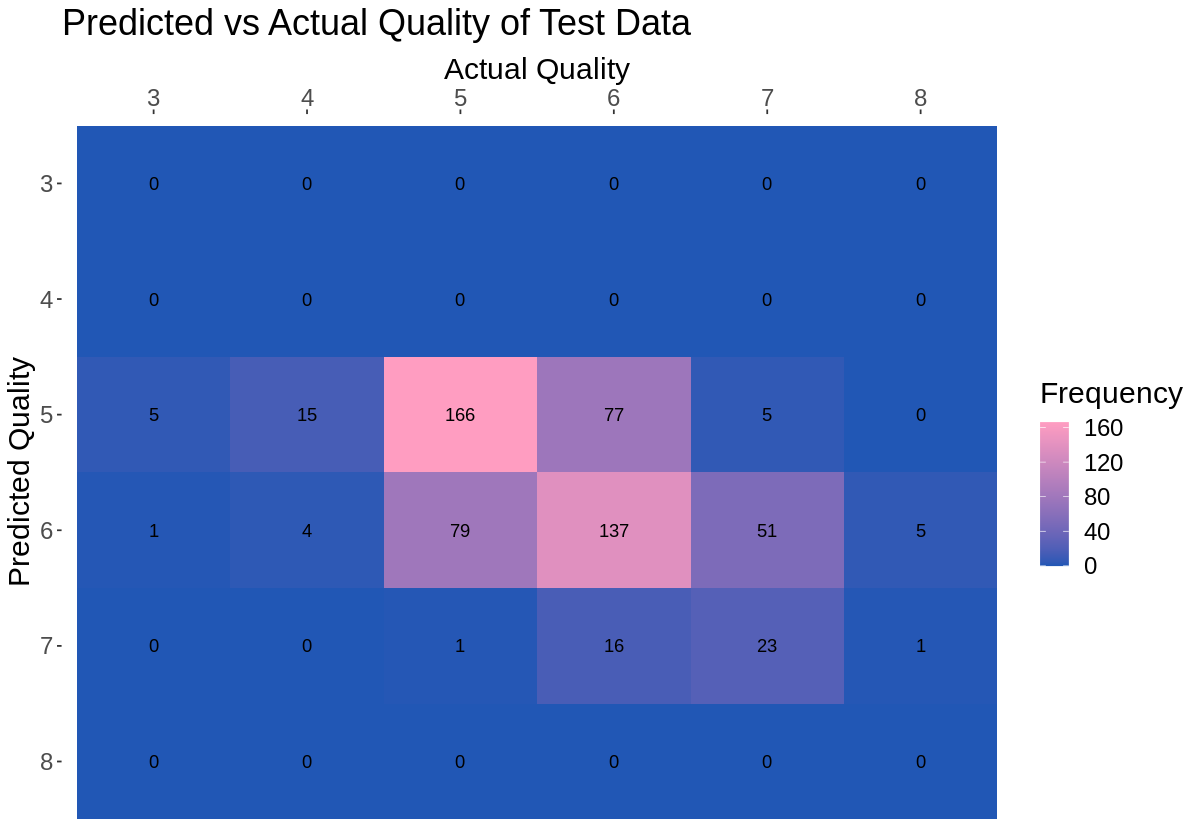

In [26]:
# creates a heatmap for the confusion matrix
confusion_plot <- confusion %>%
                  autoplot(type = "heatmap") +
                  scale_x_discrete(position = "top") +
                  scale_fill_gradient(low = "#2157b5", high = "#ff9dc1") +
                  labs(x = "Actual Quality", y = "Predicted Quality", fill = "Frequency") +
                  theme(legend.position = "right", text = element_text(size = 18)) +
                  ggtitle("Predicted vs Actual Quality of Test Data")
confusion_plot

*Figure 3.1: Heat map visualization of the classifier.*

Using a bar plot, we visualized the proportion of correct and incorrect predictions made by our model. 

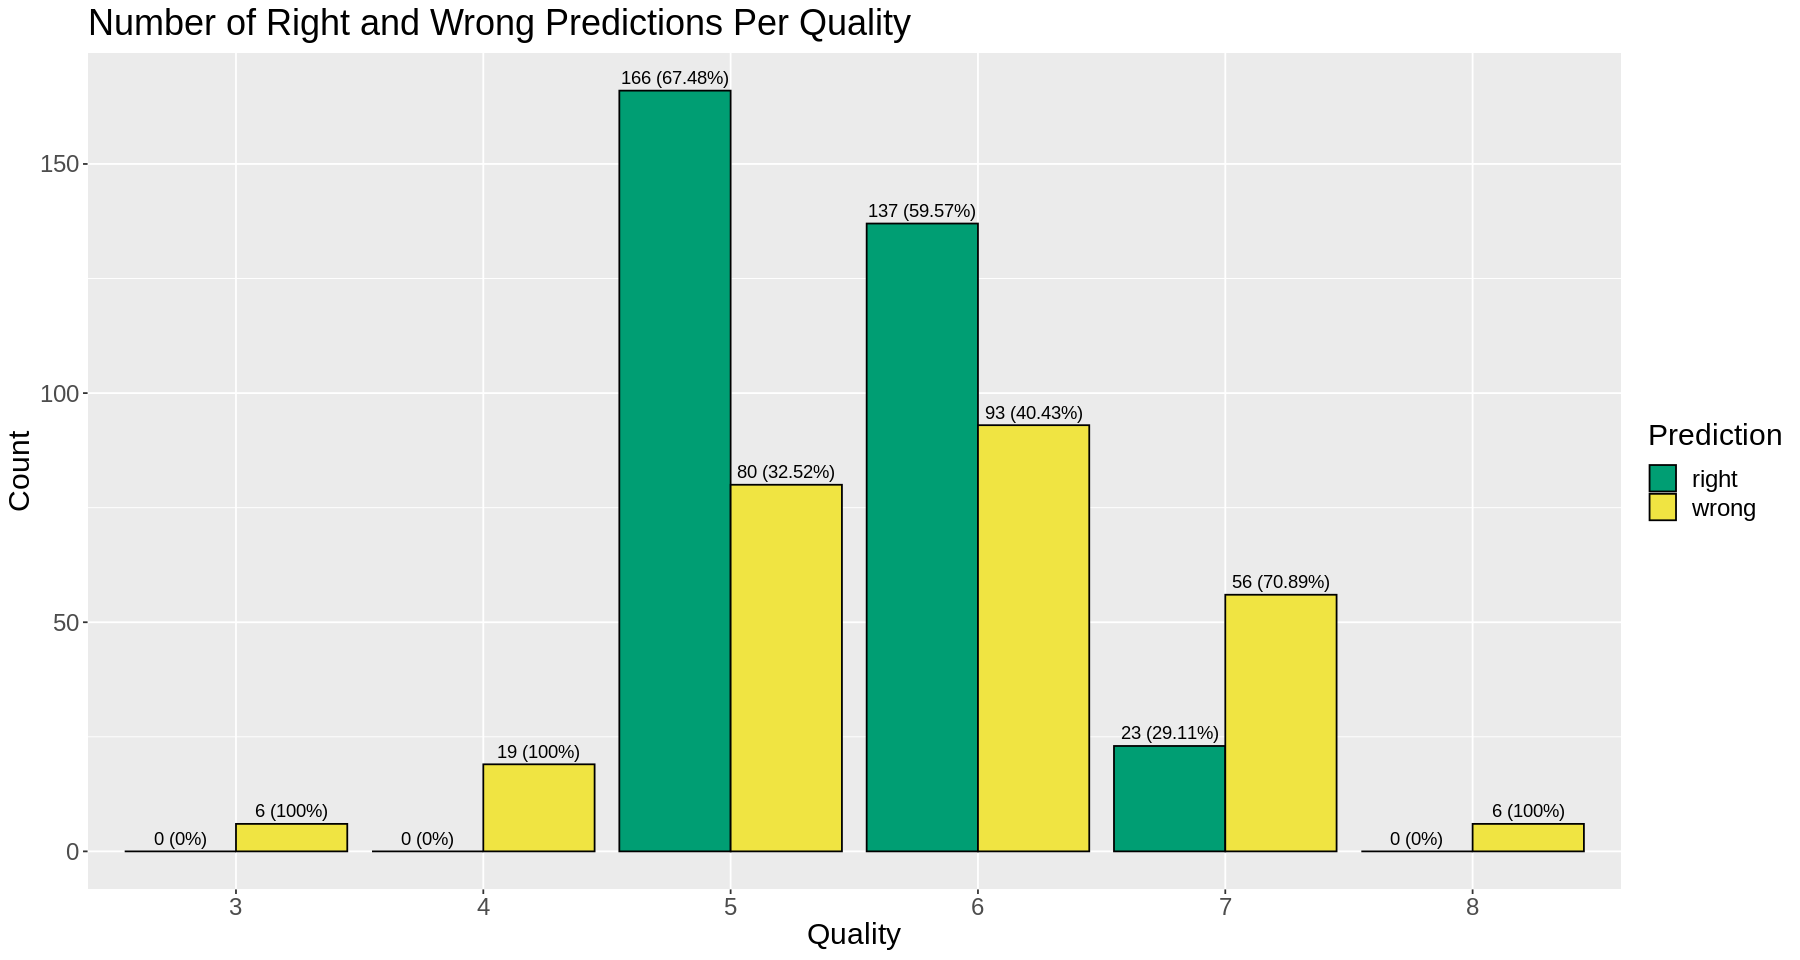

In [30]:
# converts the confusion matrix into a dataframe
confusion_df <- data.frame(confusion$table)
colnames(confusion_df)[which(names(confusion_df) == "Truth")] <- "quality"

# summarizes the number of right and wrong predictions
prediction_summary <- confusion_df %>%
                      group_by(quality) %>%
                      mutate(total_count = sum(Freq),
                             right = Freq,
                             wrong = total_count - Freq) %>%
                      filter(Prediction == quality) %>%
                      select(-Prediction, -Freq)

# produces the summarizing bar plot
options(repr.plot.width = 15, repr.plot.height = 8)
prediction_bar_plot <- prediction_summary %>%
                       pivot_longer(cols = c('right', 'wrong'),
                                    names_to = 'prediction',
                                    values_to = "count") %>%
                       ggplot(aes(x = quality, y = count, fill = prediction)) +
                       geom_col(colour = "black", position = "dodge") +
                       scale_fill_manual(values=c("#009e73", "#f0e442")) +
                       geom_text(aes(label = paste0(count, ' (', round(count * 100 / total_count, 2), '%)')),
                                 vjust = -0.5,
                                 position = position_dodge(width = .9)) +
                       theme(text = element_text(size = 18)) +
                       labs(title = "Number of Right and Wrong Predictions Per Quality", x = "Quality", y = "Count", fill = "Prediction")      
prediction_bar_plot

*Figure 3.2: Bar plot for the proportion of right and wrong predictions.*

In [63]:
# compares the ratio between right predictions and total observations
test_prediction_accuracy <- prediction_summary %>%
                            ungroup() %>%
                            select(total_count, right) %>%
                            summarize(accuracy = sum(right) / sum(total_count)) %>%
                            pull() %>%
                            round(3)
test_prediction_accuracy

[1] 0.556

The number above shows the accuracy of our current model at making predictions on our testing set.

## Discussion:

Our classification model after considering predictor selection, k-value selection, and class imbalance, produced a maximum accuracy rate of 56%. The model was most accurate in predicting average quality red wines of scores 5 and 6, failing in the high-end and low-end qualities. We expected the accuracy to improve after upsampling as we believed it was influenced by the distribution of wine quality scores in the dataset. Unfortunately, that was not the case. Thus, the accuracy of our model may be limited by the extent to which it can predict subjective classifications. As extreme cases are unable to be accurately predicted and may be influenced more by individual differences.

Our motivation for the study was to address the variability of human testers for wine quality using machine learning. Our model, although mediocre in accuracy, can streamline the wine quality assessment process and improve the repeatability of results if it was to be integrated into the human testing process. Furthermore, since the selection of predictor variables analyzed in this project are wine properties that can be controlled and manipulated during the production process, our findings can identify areas of improvement for wine production. We believe that further understanding the connection between chemical properties and the human sensory profile can further improve the quality assessment model and give producers the ability to fine-tune their wine quality.

## References:

Arapitsas, P., Guella, G., & Mattivi, F. (2018). The impact of SO2 on wine flavanols and indoles in relation to wine style and age. Scientific reports, 8(1), 858. https://doi.org/10.1038/s41598-018-19185-5

Cortez, P., Cerdeira, A., Almeida, F., Matos, T., & Reis, J. (2009). Modeling wine 
	preferences by data mining from physicochemical properties. Decision 
	Support Systems. 47, 547-553. https://doi.org/10.1016/j.dss.2009.05.016.
 
Gawel, R. & Godden, P. W. (2008). Evaluation of the consistency of wine quality assessments from expert wine tasters. Australian Journal of Grape and Wine Research. 14(1), 1-8. https://doi.org/10.1111/j.1755-0238.2008.00001.x

Gutiérrez-Escobar, R., Aliaño-González, M. J., & Cantos-Villar, E. (2021). Wine Polyphenol Content and Its 		Influence on Wine Quality and Properties: A Review. Molecules (Basel, Switzerland), 26(3), 718. https://doi.org/10.3390/molecules26030718

Radchenko, P. & James, G. M. (2011). Improved variable selection with Forward-Lasso adaptive shrinkage. The Annals of Applied Statistics. 5, 427-448. 10.1214/10-AOAS375 

Smith, D. V., & Margolskee, R. F. (2001). Making Sense of Taste. Scientific 
	American. 284, 32–39. http://www.jstor.org/stable/26059127

Timbers, T., Campbell, T., & Lee, M. (2022). Data Science: A First Introduction. CRC Press.